# Implied volatility for t = 0

No closed form solution for BSM really exists so correct solution gets estiamted (hence, implied)

In [1]:
import math
from scipy import stats
import pandas as pd
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [2]:
def bsm_call_value(S_0, K, T, r, sigma):
    """European Call option model via BSM.
    Nothing exotic or American about this, simple
    bsm w/o optimal execution time etc.
    
    Parameters
    ----------
    S_0: float
        initial stock price
    K: float
        strike price
    T: float
        time to maturity
    r: float
        interest rate
    sigma: float
        implied volatility factor in diffusion term form
    
    Returns
    -----------
    value: float
        calculated value of European Call option
    
    """
    
    s0 = float(S_0)
    d1 = (math.log(s0/K) + (r + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T)) # upper bound
    d2 = (math.log(s0/K) + (r - 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T)) # lower bound
    return (s0 * stats.norm.cdf(d1, 0., 1.0) - K * math.exp(-r * T) * stats.norm.cdf(d2, 0., 1.0))

In [3]:
def bsm_calc_vega(S_0, K, T, r, sigma):
    """Calculate sensitivity to volatility"""
    s0 = float(S_0)
    d1 = math.log(s0/K) + (r + 0.5 * sigma **2) * T / (sigma * math.sqrt(T))
    return s0 * stats.norm.cdf(d1, 0.0, 1.0) * math.sqrt(T) # Vega

In [4]:
help(stats.norm)

Help on norm_gen in module scipy.stats._continuous_distns object:

class norm_gen(scipy.stats._distn_infrastructure.rv_continuous)
 |  A normal continuous random variable.
 |  
 |  The location (loc) keyword specifies the mean.
 |  The scale (scale) keyword specifies the standard deviation.
 |  
 |  %(before_notes)s
 |  
 |  Notes
 |  -----
 |  The probability density function for `norm` is::
 |  
 |      norm.pdf(x) = exp(-x**2/2)/sqrt(2*pi)
 |  
 |  %(after_notes)s
 |  
 |  %(example)s
 |  
 |  Method resolution order:
 |      norm_gen
 |      scipy.stats._distn_infrastructure.rv_continuous
 |      scipy.stats._distn_infrastructure.rv_generic
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  fit(self, data, **kwds)
 |      Return MLEs for shape, location, and scale parameters from data.
 |      
 |      MLE stands for Maximum Likelihood Estimate.  Starting estimates for
 |      the fit are given by input arguments; for any arguments not provided
 |      with starting es

In [5]:
def bsm_call_imp_vol(S_0, K, T, r, C_0, sigma_est, it=100):
    """Implied volatility calculation of European call option in Black Scholes
    
    Parameters
    -----------
    S_0: float
        initial stock price, at time t=0
    K: float
        strike price
    T: float
        time to maturity, epoch
    r: float
        interest rate
    C_0: float
        initial call price
    sigma_est: float
        estimated implied volatility
    it: int
        number of iterations
    
    Returns
    --------
    
    estimated_sigma: float
        estimated volatility value
    
    """
    
    for i in range(it):
        sigma_est -= ((bsm_call_value(S_0, K, T, r, sigma_est) - C_0) / bsm_calc_vega(S_0, K, T,
                                                                              r, sigma_est))
    return sigma_est


In [6]:
# Run Estimation

h5 = pd.HDFStore('./vstoxx_data_31032014.h5', 'r')
futures = h5['futures_data']
options = h5['options_data']
h5.close()

In [7]:
futures

,DATE,EXP_YEAR,EXP_MONTH,PRICE,MATURITY,TTM
496,1396224000000000000,2014,4,17.85,1397779200000000000,0.049
497,1396224000000000000,2014,5,19.55,1400198400000000000,0.126
498,1396224000000000000,2014,6,19.95,1403222400000000000,0.222
499,1396224000000000000,2014,7,20.40,1405641600000000000,0.299
500,1396224000000000000,2014,8,20.70,1408060800000000000,0.375
501,1396224000000000000,2014,9,20.95,1411084800000000000,0.471
502,1396224000000000000,2014,10,21.05,1413504000000000000,0.548
503,1396224000000000000,2014,11,21.25,1416528000000000000,0.644


In [8]:
futures.describe()

,DATE,EXP_YEAR,EXP_MONTH,PRICE,MATURITY,TTM
count,8.000000e+00,8,8.00000,8.000000,8.000000e+00,8.000000
mean,1.396224e+18,2014,7.50000,20.212500,1.407002e+18,0.341750
std,0.000000e+00,0,2.44949,1.113793,6.527919e+15,0.207062
min,1.396224e+18,2014,4.00000,17.850000,1.397779e+18,0.049000
25%,1.396224e+18,2014,5.75000,19.850000,1.402466e+18,0.198000
50%,1.396224e+18,2014,7.50000,20.550000,1.406851e+18,0.337000
75%,1.396224e+18,2014,9.25000,20.975000,1.411690e+18,0.490250
max,1.396224e+18,2014,11.00000,21.250000,1.416528e+18,0.644000


In [9]:
futures.head()
options.head()

,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY,TTM
46170,1396224000000000000,2014,4,C,1,16.85,1397779200000000000,0.049
46171,1396224000000000000,2014,4,C,2,15.85,1397779200000000000,0.049
46172,1396224000000000000,2014,4,C,3,14.85,1397779200000000000,0.049
46173,1396224000000000000,2014,4,C,4,13.85,1397779200000000000,0.049
46174,1396224000000000000,2014,4,C,5,12.85,1397779200000000000,0.049


In [10]:
# initiate new column for implied volatility

options['ImpliedVol'] = 0.
options.head()


,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY,TTM,ImpliedVol
46170,1396224000000000000,2014,4,C,1,16.85,1397779200000000000,0.049,0
46171,1396224000000000000,2014,4,C,2,15.85,1397779200000000000,0.049,0
46172,1396224000000000000,2014,4,C,3,14.85,1397779200000000000,0.049,0
46173,1396224000000000000,2014,4,C,4,13.85,1397779200000000000,0.049,0
46174,1396224000000000000,2014,4,C,5,12.85,1397779200000000000,0.049,0


In [11]:
help(options.loc)

Help on _LocIndexer in module pandas.core.indexing object:

class _LocIndexer(_LocationIndexer)
 |  Purely label-location based indexer for selection by label.
 |  
 |  ``.loc[]`` is primarily label based, but may also be used with a
 |  boolean array.
 |  
 |  Allowed inputs are:
 |  
 |  - A single label, e.g. ``5`` or ``'a'``, (note that ``5`` is
 |    interpreted as a *label* of the index, and **never** as an
 |    integer position along the index).
 |  - A list or array of labels, e.g. ``['a', 'b', 'c']``.
 |  - A slice object with labels, e.g. ``'a':'f'`` (note that contrary
 |    to usual python slices, **both** the start and the stop are included!).
 |  - A boolean array.
 |  
 |  ``.loc`` will raise a ``KeyError`` when the items are not found.
 |  
 |  See more at :ref:`Selection by Label <indexing.label>`
 |  
 |  Method resolution order:
 |      _LocIndexer
 |      _LocationIndexer
 |      _NDFrameIndexer
 |      builtins.object
 |  
 |  Methods inherited from _LocationIndex

In [12]:
tol = 0.5
V0 = 17.6639
r = 0.005
for option in options.index:
    forward = futures[futures["MATURITY"] == options.loc[option]['MATURITY']]['PRICE'].values[0]
    if (forward * (1 - tol) < options.loc[option]['STRIKE'] < forward * (1 + tol)):
        implied_vol =bsm_call_imp_vol(V0, options.loc[option]['STRIKE'],
                                     options.loc[option]['TTM'], 
                                      r,
                                     options.loc[option]['PRICE'],
                                     2,
                                     100)
        options['ImpliedVol'].loc[option] = implied_vol
        

/Users/arkilic/anaconda/envs/py34/lib/python3.4/site-packages/pandas/core/indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
futures['MATURITY']

496    1397779200000000000
497    1400198400000000000
498    1403222400000000000
499    1405641600000000000
500    1408060800000000000
501    1411084800000000000
502    1413504000000000000
503    1416528000000000000
Name: MATURITY, dtype: int64

In [14]:
options.loc[46170]

DATE          1396224000000000000
EXP_YEAR                     2014
EXP_MONTH                       4
TYPE                            C
STRIKE                          1
PRICE                       16.85
MATURITY      1397779200000000000
TTM                         0.049
ImpliedVol                      0
Name: 46170, dtype: object

In [15]:
options.loc[46170]['STRIKE']

1.0

In [16]:
plot_data = options[options['ImpliedVol'] > 0]

In [17]:
plot_data.info()
plot_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158 entries, 46178 to 46545
Data columns (total 9 columns):
DATE          158 non-null int64
EXP_YEAR      158 non-null int64
EXP_MONTH     158 non-null int64
TYPE          158 non-null object
STRIKE        158 non-null float64
PRICE         158 non-null float64
MATURITY      158 non-null int64
TTM           158 non-null float64
ImpliedVol    158 non-null float64
dtypes: float64(4), int64(4), object(1)
memory usage: 12.3+ KB


,DATE,EXP_YEAR,EXP_MONTH,TYPE,STRIKE,PRICE,MATURITY,TTM,ImpliedVol
46178,1396224000000000000,2014,4,C,9,8.85,1397779200000000000,0.049,2.088654
46179,1396224000000000000,2014,4,C,10,7.85,1397779200000000000,0.049,1.809408
46180,1396224000000000000,2014,4,C,11,6.85,1397779200000000000,0.049,1.555378
46181,1396224000000000000,2014,4,C,12,5.85,1397779200000000000,0.049,1.321006
46182,1396224000000000000,2014,4,C,13,4.85,1397779200000000000,0.049,1.101818


In [18]:
maturities = sorted(set(options['MATURITY']))

1397779200000000000 1449371580.715278
1400198400000000000 1449371580.768492
1403222400000000000 1449371580.77281
1405641600000000000 1449371580.776495
1408060800000000000 1449371580.780343
1411084800000000000 1449371580.783963
1413504000000000000 1449371580.788313
1416528000000000000 1449371580.79283


/Users/arkilic/anaconda/envs/py34/lib/python3.4/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


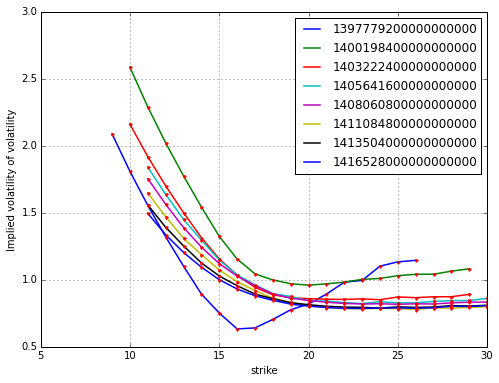

In [19]:
plt.figure(figsize=(8, 6))
import datetime
for mat in maturities:
    data = plot_data[options.MATURITY ==mat]
    plt.plot(data['STRIKE'], data['ImpliedVol'], 
             lw=1.5, label=mat)
    plt.plot(data['STRIKE'], data['ImpliedVol'], 'r.')
plt.grid(True)
plt.xlabel('strike')
plt.ylabel('Implied volatility of volatility')
plt.legend()
plt.show()